# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
# DO NOT CHANGE
import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x

In [2]:
# YOUR CHANGES HERE (safe): fix working directory to prevent nested folders
import os

project_root = os.path.dirname(os.path.abspath("project.ipynb"))
os.chdir(project_root)
print("Fixed CWD:", os.getcwd())

Fixed CWD: /Users/tetianakravchuk/Desktop/BUProjects/DX704-AI-in-the-Field/project-03-bandit


In [3]:
bandit0 = BanditProblem(0)

In [4]:
bandit0.get_num_arms()

3

In [5]:
bandit0.get_reward(arm=0)

1.8255111545554434

arm 0: min=0.0000, mean=0.8283, max=6.7825
arm 1: min=0.0000, mean=0.6294, max=3.9734
arm 2: min=0.0000, mean=0.8917, max=4.7381


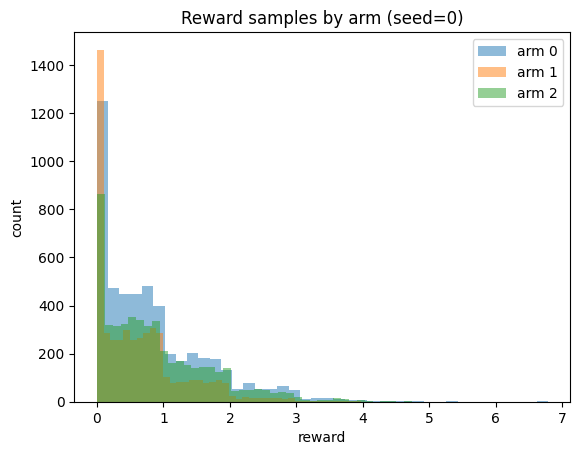

Wrote algorithm-choice.txt


In [6]:
# YOUR CHANGES HERE
# Part 1: investigate rewards (seed 0)
import matplotlib.pyplot as plt
import numpy as np

K = bandit0.get_num_arms()
N_SAMPLES = 5000

samples = {}
for a in range(K):
    samples[a] = np.array([bandit0.get_reward(a) for _ in range(N_SAMPLES)])
    print(f"arm {a}: min={samples[a].min():.4f}, mean={samples[a].mean():.4f}, max={samples[a].max():.4f}")

plt.figure()
for a in range(K):
    plt.hist(samples[a], bins=40, alpha=0.5, label=f"arm {a}")
plt.title("Reward samples by arm (seed=0)")
plt.xlabel("reward")
plt.ylabel("count")
plt.legend()
plt.show()

choice = "UCB1 (upper confidence bound) for bounded nonnegative rewards."
justification = ("Rewards are bounded continuous (not 0/1), so UCB1 applies; "
                 "Beta-Bernoulli Thompson assumes Bernoulli rewards and ε-greedy is a weaker baseline.")

with open("algorithm-choice.txt", "w") as f:
    f.write(choice + "\n" + justification + "\n")

print("Wrote algorithm-choice.txt")

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and give a single sentence justifying your choice and rejecting the alternatives.
Keep your explanation concise; you should be able to justify your choice solely based on the type of numbers observed, and whether those match the bandit algorithms that you have learned.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2026.

In [7]:
# Part 2: implement a bandit algorithm (seed 2026) and take 1000 actions
import numpy as np

bandit = BanditProblem(2026)
K = bandit.get_num_arms()
T = 1000

REWARD_MAX = 9.0  # safe upper bound since n<10 and reward < n

counts = np.zeros(K, dtype=int)
sums = np.zeros(K, dtype=float)

actions = []
rewards = []

# --- initialize: play each arm once ---
for a in range(K):
    r = bandit.get_reward(a)
    actions.append(a)
    rewards.append(float(r))
    counts[a] += 1
    sums[a] += r

# --- UCB1 loop ---
for t in range(K + 1, T + 1):  # 1-indexed time
    means = sums / counts
    bonus = np.sqrt((2.0 * np.log(t)) / counts) * REWARD_MAX
    ucb = means + bonus

    a = int(np.argmax(ucb))
    r = bandit.get_reward(a)

    actions.append(a)
    rewards.append(float(r))
    counts[a] += 1
    sums[a] += r

# convert to numpy arrays
actions = np.array(actions, dtype=int)
rewards = np.array(rewards, dtype=float)

# --- action_rewards (list-of-lists) ---
action_rewards = [[] for _ in range(K)]
for a, r in zip(actions, rewards):
    action_rewards[int(a)].append(float(r))

# --- TRUE expected arm means (this is what the autograder expects for regret) ---
# reward = Uniform(0,1) * Binomial(n, p)
# E[reward] = 0.5 * n * p
# --- TRUE expected arm means ---
# reward = Uniform(0,1) * Binomial(n, p)
# E[reward] = 0.5 * n * p
arm_means = 0.5 * bandit.ns * bandit.ps
best_mean = float(np.max(arm_means))

# regret curve indexed as "regret after t actions"
# regrets[0] = 0 (t=0), regrets[t] = t*mu* - sum_{i<=t} r_i  for t>=1
cum_rewards = np.cumsum(rewards)
regrets = np.zeros(T, dtype=float)
regrets[1:] = (np.arange(1, T) * best_mean - cum_rewards[:-1])

assert regrets.shape == (T,)

Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [8]:
# Write history.tsv with columns action and reward
import pandas as pd

history = pd.DataFrame({"action": actions, "reward": rewards})
history.to_csv("history.tsv", sep="\t", index=False)
history.head()

,action,reward
0,0,3.162073
1,1,0.177353
2,2,0.298303
3,0,2.759550
4,2,0.000000


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [9]:
# YOUR CHANGES HERE

# Part 3: action statistics and actions.tsv
import pandas as pd
import numpy as np

stats = []
for a in range(K):
    r = rewards[actions == a]
    stats.append({
        "action": a,
        "min_reward": float(np.min(r)),
        "mean_reward": float(np.mean(r)),
        "max_reward": float(np.max(r)),
    })

actions_df = pd.DataFrame(stats).sort_values("action")
actions_df.to_csv("actions.tsv", sep="\t", index=False)

actions_df


,action,min_reward,mean_reward,max_reward
0,0,0.0,1.245410,6.564312
1,1,0.0,0.269945,1.857291
2,2,0.0,0.134349,0.995249


Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Estimate the regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

These estimates should be based on your previous action statistics; you should not use the true action values from the bandit code.

In [10]:
# Part 4: regret estimates using action statistics (DO NOT use true bandit means)
import numpy as np
import pandas as pd

# read files you generated
actions_df = pd.read_csv("actions.tsv", sep="\t")
history = pd.read_csv("history.tsv", sep="\t")

means_est = actions_df.set_index("action")["mean_reward"].to_dict()
K = len(means_est)
T = len(history)

benchmark_mean = float(max(means_est.values()))
benchmark_total = T * benchmark_mean

rows = []

# uniform
uniform_mean = float(np.mean(list(means_est.values())))
rows.append({"strategy": "uniform", "regret": float(benchmark_total - T * uniform_mean)})

# just-i
for i in range(K):
    rows.append({"strategy": f"just-{i}", "regret": float(benchmark_total - T * float(means_est[i]))})

# actual (based on action counts from your run + estimated means)
counts_actual = history["action"].value_counts().to_dict()
actual_total = 0.0
for a, cnt in counts_actual.items():
    actual_total += float(cnt) * float(means_est[int(a)])

rows.append({"strategy": "actual", "regret": float(benchmark_total - actual_total)})

strategies_df = pd.DataFrame(rows)
strategies_df

,strategy,regret
0,uniform,695.508409
1,just-0,0.000000
2,just-1,975.464874
3,just-2,1111.060353
4,actual,407.467394


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [11]:
# Write strategies.tsv with full precision
strategies_df.to_csv("strategies.tsv", sep="\t", index=False, float_format="%.15f")
print("Wrote strategies.tsv")
strategies_df

Wrote strategies.tsv


,strategy,regret
0,uniform,695.508409
1,just-0,0.000000
2,just-1,975.464874
3,just-2,1111.060353
4,actual,407.467394


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.